# Quantization Modes


In [4]:
# define imports
import numpy as np
from pathlib import Path

from quantization_notes.utils.utils import plot_table

OUTPUT_DIR = Path("../output")

## Symmetric Quantization

In symmetric quantization, we map the floating-point range to the quantized range with respect to 0. To do so, we choose the maximum absolute value between the min/max of the floating-point range i.e. $max|x_f| = -max(x_f) $ or $max(x_f)$, where $x_f$ is some number in the floating-point range. Additionally, we choose $N_{bins} = 2^n$, where $n$ is the number of bits we want to quantize to.

Example: Let's say we wanted an 8-bit quantization range. Then, the number of bins would be $N_{bins} = 2^8 = 256 \implies [0,255] \implies [-128,127]$. That is the "full range" symmetric around 0. However in practice, this range is generally "restricted" to $[-127,127]$. We can derive scaling factors to map from floating point to quantized for both ranges:

$$
\def\arraystretch{1.5}
\begin{array}{c|c|c}
& \text{Full Range} & \text{Restricted Range} \\ \hline
\text{Quantized Range} & [-\frac{N_{bins}}{2},\frac{N_{bins}}{2}-1] & [-(\frac{N_{bins}}{2}-1),\frac{N_{bins}}{2}-1] \\ \hline
\text{8-bit Example} & [-128,127] & [-127,127] \\ \hline
\text{Scale Factor} & q_x=\frac{(2^n-1)/2}{max(|x_f|)} & q_x=\frac{2^{n-1}-1}{max(|x_f|)} \\
\end {array}
$$

Finally, we can compute our symmetric quantized tensor:

$$x_q = \text{round}(q_xx_f)$$


In [5]:
def quantize_symmetric_full(n: int, x_f: np.array) -> np.array:
    q_x = ((pow(2, n) - 1) / 2) / np.max(np.abs(x_f))
    x_q = np.round(q_x * x_f)
    return x_q


def quantize_symmetric_restricted(n: int, x_f: np.array) -> np.array:
    q_x = (pow(2, n - 1) - 1) / np.max(np.abs(x_f))
    x_q = np.round(q_x * x_f)
    return x_q


data = np.random.uniform(-1000, 1000, size=(5, 5))
print(f"unquantized data:\n {data} \n")


# In Python the smallest data type is bool which is 8 bits,
# unfortunately we can't do any smaller here
quantized_symmetric_full_data = quantize_symmetric_full(8, data).astype(np.int8)
print(f"quantize symmetric full\n {quantized_symmetric_full_data} \n")

quantized_symmetric_restricted_data = quantize_symmetric_restricted(8, data).astype(
    np.int8
)
print(f"quantize symmetric restricted\n {quantized_symmetric_restricted_data} \n")

unquantized data:
 [[ 920.43499169   56.12315003 -519.82370368 -127.69951907  538.74474696]
 [ 457.21014693 -156.58335502  131.67928493  177.12128332  455.9502606 ]
 [ 179.99519968   31.70768757  785.55276696 -829.57746107  413.65820478]
 [-767.62183388  860.64301704  286.39770061 -224.4204855  -552.61130557]
 [ 783.20187872 -736.62042589  823.83643755  453.68737029 -272.81533576]] 

quantize symmetric full
 [[ 127    8  -72  -18   75]
 [  63  -22   18   25   63]
 [  25    4  109 -115   57]
 [-106  119   40  -31  -77]
 [ 108 -102  114   63  -38]] 

quantize symmetric restricted
 [[ 127    8  -72  -18   74]
 [  63  -22   18   24   63]
 [  25    4  108 -114   57]
 [-106  119   40  -31  -76]
 [ 108 -102  114   63  -38]] 



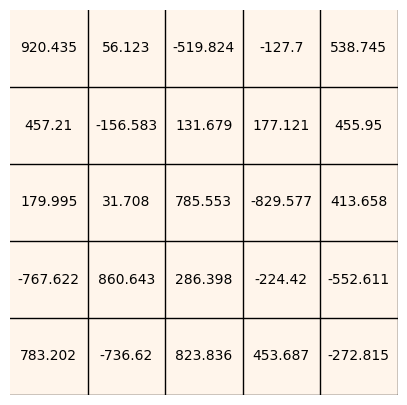

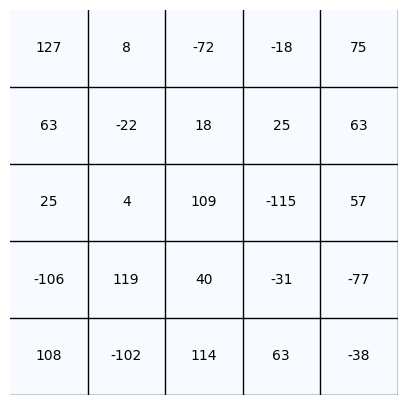

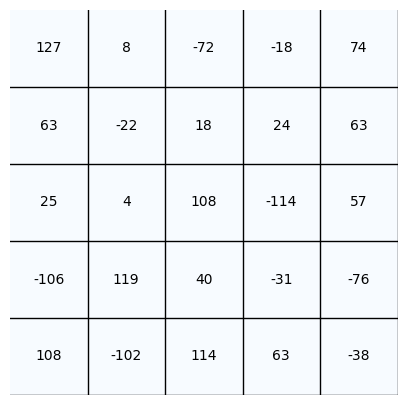

In [6]:
plot_table(data, str(OUTPUT_DIR / "unquantized-data.png"), "Oranges", "black", "black")
plot_table(
    quantized_symmetric_full_data,
    str(OUTPUT_DIR / "quantized-symmetric-full.png"),
    "Blues",
    "black",
    "black",
)
plot_table(
    quantized_symmetric_restricted_data,
    str(OUTPUT_DIR / "quantized-symmetric-restricted.png"),
    "Blues",
    "black",
    "black",
)

## Dequantization and Error

Dequantization of a symmetric quantization is as simple as computing the product of the scale factor $q_x$ and the quantized tensor $x_q$ or $x_f = q_xx_q$. However as expected, there is some error associated with the process of quantizing the original tensor and then dequantizing it back. We can compute that error using mean-squared error (MSE):

$$
\text{MSE} = \frac{1}{n}\displaystyle\sum_{i=1}^n(x-y)^2
$$
